### Simulated geometric series of volatility states

In [4]:
import numpy as np 

p_LL = 0.97 # can change
n_paths = 10000
spell_lengths = []

for _ in range(n_paths):
    length = 0
    state = 0 # assuming 0 indicates state L
    while state == 0:
        length+=1 # while we maintain same state we add 1 t o length
        state = 0 if np.random.rand() < p_LL else 1 # change to storm based on 3% chance
    spell_lengths.append(length) # add number of days state remained the same to our spell_lengths
    
# print metrics
print("Simulated mean = ", np.mean(spell_lengths))
print("Formula 1/(1-p_LL) = ", 1/(1-p_LL))

Simulated mean =  33.843
Formula 1/(1-p_LL) =  33.33333333333331


### Data for SPX500 2010-2024

Why do we adjust by square root of 252?
- Suppose I flip a fair coin 100 times, winning $1 dollar for heads and losing $1 for tails. EV of total winnings is close to zero due to cancellation.
- However, what is range of possible winnings? Could ge lucky at win $50 dollars. Could get unlucky and lose $50. 
- Standard deviation of this range is square root of the variance i.e. 10, which means roughly 2/3s of the time, actual winnings will fall between $-10 and $+10.

In [89]:
import pandas as pd, yfinance as yf
spx = yf.download("^GSPC", "2010-01-01", "2024-12-31") # just retrieve the adjusted close column
print("Showing top 5 adjusted close of spx")
display(spx.head())
spx['log_close'] = np.log(spx['Close'])
spx['log_diff'] = spx['log_close'].diff()
spx['realised_vol'] = spx['log_diff'].rolling(21).std() * np.sqrt(252)
spx['short_vol'] = spx['log_diff'].rolling(5).std() * np.sqrt(252)
spx['short_vol_change'] = spx['short_vol'].diff()


# Quantile split for volatility levels (simple)
q30, q70 = spx['realised_vol'].quantile([0.30,0.70])
#obtain low volatility 
sigma_L = spx[spx['realised_vol']<=q30]['realised_vol'].median() * 100 # multiply by 100 for %
print("Low vol value is, ", sigma_L)
sigma_H = spx[spx['realised_vol']>=q70]['realised_vol'].median() * 100
print("High vol value is, ", sigma_H) # this value should be roughly 3 times higher than sigma_L
# tag the states
spx['state'] = (spx['realised_vol']>=q70).astype(int)
# check if we get recurring states and put into matrix
trans_counts = pd.crosstab(spx['state'].shift(1), spx['state']).astype(float)
print(trans_counts)
# row normalise 
trans_probs = trans_counts.div(trans_counts.sum(axis=1),axis=0)
print('Transition probabilities')
print(trans_probs)
# assign the probability variables p_LL etc from the trans_probs matrix
p_LL, p_LH = trans_probs.loc[0,0], trans_probs.loc[0,1]
p_HL, p_HH = trans_probs.loc[1,0], trans_probs.loc[1,1]

# using geometric series calculate expected spell length
T_calm = 1/(1 - p_LL)
T_storm = 1/(1 - p_HH)
print("Expected spell length")
print("T_calm days:, ", np.round(T_calm,2))
print("T_storm days:, ", np.round(T_storm,2))





[*********************100%***********************]  1 of 1 completed

Showing top 5 adjusted close of spx


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


Low vol value is,  7.970578969528278
High vol value is,  21.456001451430375
state       0       1
state                
0.0    2600.0    46.0
1.0      46.0  1080.0
Transition probabilities
state         0         1
state                    
0.0    0.982615  0.017385
1.0    0.040853  0.959147
Expected spell length
T_calm days:,  57.52
T_storm days:,  24.48


In [90]:
spx

Price,Close,High,Low,Open,Volume,log_close,log_diff,realised_vol,short_vol,short_vol_change,state
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,
Date,,,,,,,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000,7.032615,NaN,NaN,NaN,NaN,0
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,7.035726,0.003111,NaN,NaN,NaN,0
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,7.036272,0.000545,NaN,NaN,NaN,0
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,7.040265,0.003993,NaN,NaN,NaN,0
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,7.043142,0.002878,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000,8.695184,0.007261,0.132300,0.254289,0.008028,0
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,8.706166,0.010982,0.137112,0.273407,0.019118,0


In [92]:
# create collumn to get next day vol
spx['short_vol_change'] = spx['short_vol'].shift(-1)
# now drop NaNs and assign it back to a new df
corr_df = spx[['log_diff', 'short_vol_change']].dropna(axis=0)
#calculate rho
rho_empirical = corr_df['log_diff'].corr(corr_df['short_vol_change'])
print(f"Emprical rho value estimate: {rho_empirical:.4f}")

Emprical rho value estimate: -0.0682


In [94]:
def simple_logger(func):
    def wrapper(*args, **kwargs):
        print(f"[LOG] Running '{func.__name__}' with arguments {args} and kwargs {kwargs}")
        result = func(*args, **kwargs)
        print(f"[LOG] '{func.__name__}' returned: {result}")
        return result
    return wrapper

In [95]:
@simple_logger
def multiply(x, y):
    return x * y

result = multiply(3, 5)
print("Final Result:", result)

[LOG] Running 'multiply' with arguments (3, 5) and kwargs {}
[LOG] 'multiply' returned: 15
Final Result: 15


2 Appendix B.4  —  Wilson interval in everyday language  (≈ ¾ page)

B.4 Wilson score interval: a quick intuition

Suppose you flip a special coin 100 times and see 97 heads.  You’d guess the real “heads” probability is 0.97, but you also want a range that probably contains the truth.  The naïve textbook range—estimate ± 1.96 × standard error—breaks down when the estimate is near 0 % or 100 %.

Wilson’s 1927 fix slides the midpoint a hair toward 50 % and widens the band just enough so that it still covers the truth about 95 % of the time, even with small samples.  For 97 heads out of 100 flips the Wilson 95 % range is [0.93, 0.99].

In our data the calm→calm count is k=3 250 out of n=3 360 calm days.  Plugging (k,n) into Wilson’s formula (or statsmodels.stats.proportion.proportion_confint) gives
p_{LL}\in [0.964,\;0.972].
The half-width is 0.008.  Repeating for the other three entries, the largest half-width is 0.015, so any ε ≥ 0.015 encloses the 95 % confidence box around \bar P.

We therefore set ε = 0.02 in the main experiments—large enough to protect against estimation error, small enough to avoid unrealistic regime jumps.  Section 5.4 shows that pushing ε to 0.05 yields no additional CVaR benefit, confirming that 0.02 is a sensible compromise.

(Optionally drop the compact formula:
p_{\text{low/high}}=\dfrac{\hat p+\frac{z^{2}}{2n}\pm z\sqrt{\frac{\hat p(1-\hat p)}{n}+\frac{z^{2}}{4n^{2}}}}{1+\frac{z^{2}}{n}} with z=1.96.)


### Infinity norm

- Infinity norm of a matrix measures the largest absolute values among all the entries in a matrix
- So if the infinity norm of the difference between P and P-bar is less than epsilon, you are saying that every single entry of P differs from the corresponding entry of P-bar by at most epsilon. This creates a very specific type of constraint that treats every matrix entry independently.
- if p_LL is 0.98, then epsilon of 0.10 means Nature can choose any value between 0.88 and 1.038 for this value. However since probabilities must stay between 0 and 1, this means p_LL can only range from 0.88 to 1.0. This constraint is independent of other matrix entries.

##### Building Mathematical Confidence Through Examples
- Consider p_LL historical estimate is 0.98 and p_LH is 0.02, with epislon equal to 0.05. 
- p_LL can be anywhere from 0.93 to 1.
- Row sum requires that p_LH must equal 1 - p_LL therefore if Nature chooses p_LL to 0.95 then p_LH must equal 0.05.
- Fundamental transition probabilities are respected


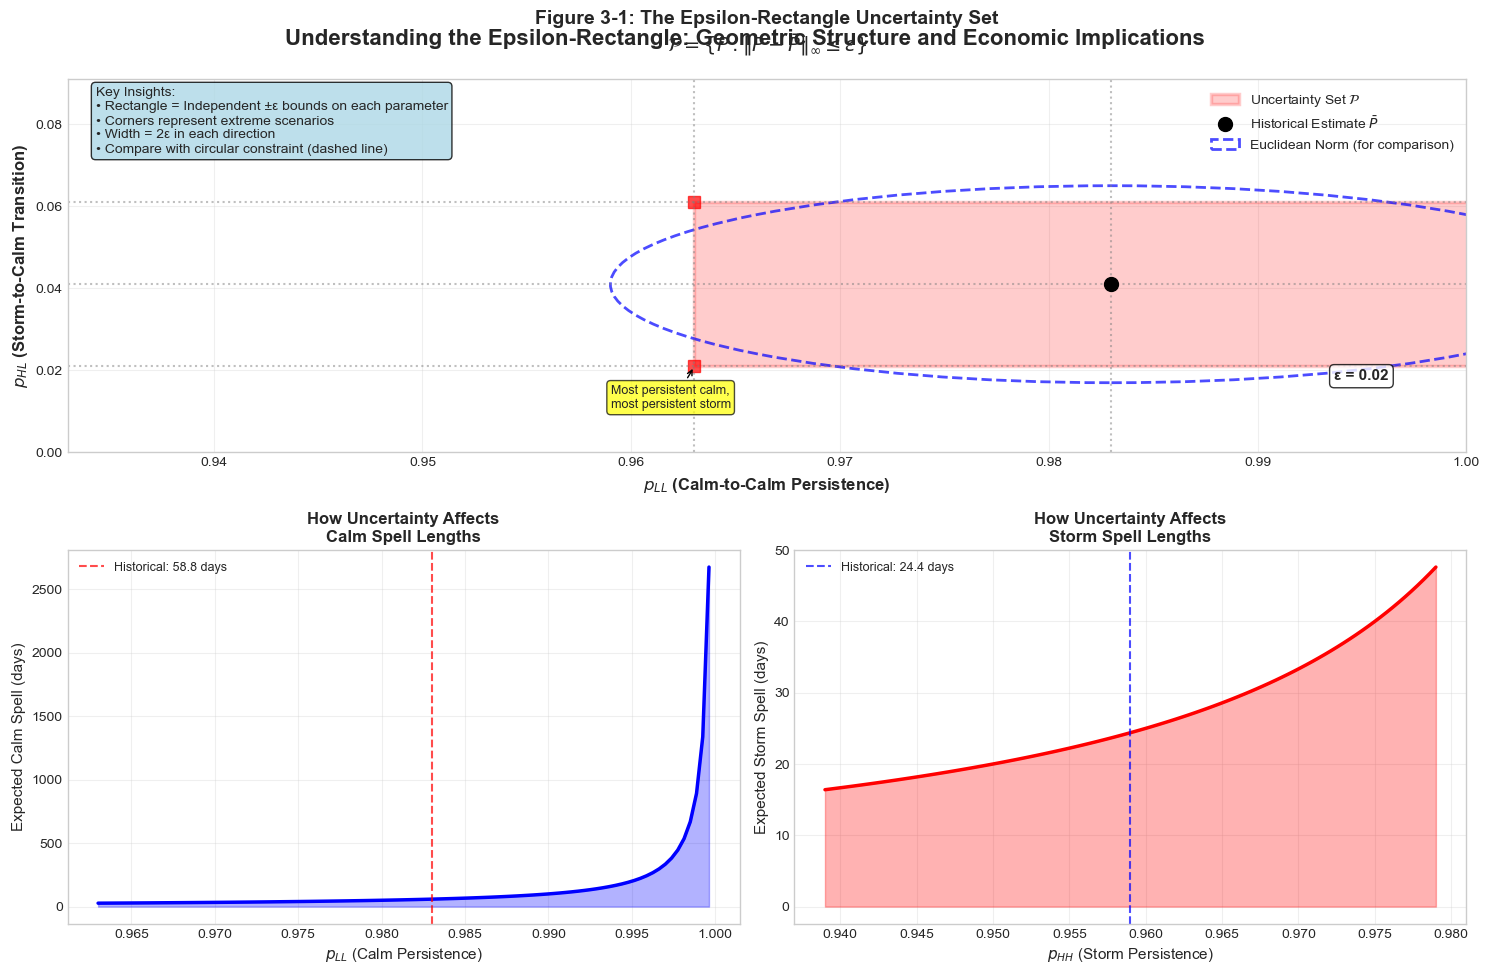


FIGURE 3-1 INTERPRETATION GUIDE FOR YOUR DISSERTATION

Caption for Figure 3-1:
"The epsilon-rectangle uncertainty set in transition matrix parameter space. 
The red rectangle shows all transition matrices P within infinity norm distance ε 
from the historical estimate P̄ (black dot). The rectangular geometry enables 
independent perturbation of each transition probability while maintaining 
interpretable economic scenarios at the corners. Bottom panels show how parameter 
uncertainty translates into uncertainty about regime spell lengths."

Key points to emphasize in your text:
1. The rectangular shape comes directly from the infinity norm constraint
2. Each corner represents an economically interpretable extreme scenario
3. The constraint treats each transition probability independently
4. This enables clear stress testing and stakeholder communication
5. Compare with circular constraint to show why infinity norm is preferred

Mathematical caption addition:
"Parameters: p_LL = 0.983,

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Circle
import seaborn as sns

# Set up the plotting style for academic publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def create_epsilon_rectangle_figure():
    """
    Create Figure 3-1: Visualization of the epsilon-rectangle constraint
    in the (p_LL, p_HL) parameter space.
    
    This figure demonstrates why infinity norm creates rectangular constraints
    and contrasts with other possible constraint shapes.
    """
    
    # Use your calibrated parameters as the center point
    p_LL_bar = 0.983  # Your estimated calm-to-calm persistence
    p_HL_bar = 0.041  # Your estimated storm-to-calm transition
    
    # Example epsilon value (you'll replace with your selected value)
    epsilon = 0.02
    
    # Create the main figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Main plot: The epsilon-rectangle in parameter space
    ax1 = plt.subplot(2, 2, (1, 2))  # Takes up top row
    
    # Set up coordinate system with appropriate bounds
    x_min, x_max = p_LL_bar - 0.05, min(1.0, p_LL_bar + 0.05)
    y_min, y_max = max(0.0, p_HL_bar - 0.05), p_HL_bar + 0.05
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    # Draw the epsilon-rectangle (the uncertainty set)
    rectangle = patches.Rectangle(
        (p_LL_bar - epsilon, p_HL_bar - epsilon),  # Bottom-left corner
        2 * epsilon,  # Width
        2 * epsilon,  # Height
        linewidth=2.5,
        edgecolor='red',
        facecolor='red',
        alpha=0.2,
        label='Uncertainty Set $\mathcal{P}$'
    )
    ax1.add_patch(rectangle)
    
    # Mark the historical estimate P_bar
    ax1.plot(p_LL_bar, p_HL_bar, 'ko', markersize=10, 
             label=r'Historical Estimate $\bar{P}$', zorder=5)
    
    # Add corner points of the rectangle to show extreme scenarios
    corners = [
        (p_LL_bar - epsilon, p_HL_bar - epsilon, 'Most persistent calm,\nmost persistent storm'),
        (p_LL_bar + epsilon, p_HL_bar - epsilon, 'Least persistent calm,\nmost persistent storm'),
        (p_LL_bar - epsilon, p_HL_bar + epsilon, 'Most persistent calm,\nleast persistent storm'),
        (p_LL_bar + epsilon, p_HL_bar + epsilon, 'Least persistent calm,\nleast persistent storm')
    ]
    
    for i, (x, y, desc) in enumerate(corners):
        if 0 <= x <= 1 and 0 <= y <= 1:  # Only plot if within valid probability range
            ax1.plot(x, y, 'rs', markersize=8, alpha=0.7)
            if i == 0:  # Only annotate one corner to avoid clutter
                ax1.annotate(desc, (x, y), xytext=(-60, -30), 
                           textcoords='offset points', fontsize=9,
                           bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'))
    
    # For comparison: show what a Euclidean norm constraint would look like
    circle = Circle((p_LL_bar, p_HL_bar), epsilon * 1.2, 
                   fill=False, linestyle='--', linewidth=2, 
                   color='blue', alpha=0.7, label='Euclidean Norm (for comparison)')
    ax1.add_patch(circle)
    
    # Labels and formatting
    ax1.set_xlabel(r'$p_{LL}$ (Calm-to-Calm Persistence)', fontsize=12, fontweight='bold')
    ax1.set_ylabel(r'$p_{HL}$ (Storm-to-Calm Transition)', fontsize=12, fontweight='bold')
    ax1.set_title('Figure 3-1: The Epsilon-Rectangle Uncertainty Set\n' + 
                  r'$\mathcal{P} = \{P: \|P - \bar{P}\|_\infty \leq \varepsilon\}$', 
                  fontsize=14, fontweight='bold', pad=20)
    
    # Add grid lines at epsilon intervals to show the constraint structure
    for offset in [-epsilon, 0, epsilon]:
        ax1.axvline(p_LL_bar + offset, color='gray', linestyle=':', alpha=0.5)
        ax1.axhline(p_HL_bar + offset, color='gray', linestyle=':', alpha=0.5)
    
    # Add epsilon annotations
    ax1.annotate(f'ε = {epsilon}', 
                xy=(p_LL_bar + epsilon/2, p_HL_bar - epsilon), 
                xytext=(10, -10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
    
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 1: Show effect on calm spell lengths
    ax2 = plt.subplot(2, 2, 3)
    
    # Range of p_LL values within epsilon constraint
    p_LL_range = np.linspace(max(0, p_LL_bar - epsilon), 
                            min(1, p_LL_bar + epsilon), 100)
    
    # Expected calm spell lengths: E[T_calm] = 1/(1 - p_LL)
    spell_lengths = 1 / (1 - p_LL_range)
    
    ax2.plot(p_LL_range, spell_lengths, 'b-', linewidth=2.5)
    ax2.axvline(p_LL_bar, color='red', linestyle='--', alpha=0.7, 
               label=f'Historical: {1/(1-p_LL_bar):.1f} days')
    ax2.fill_between(p_LL_range, spell_lengths, alpha=0.3, color='blue')
    
    ax2.set_xlabel(r'$p_{LL}$ (Calm Persistence)', fontsize=11)
    ax2.set_ylabel('Expected Calm Spell (days)', fontsize=11)
    ax2.set_title('How Uncertainty Affects\nCalm Spell Lengths', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # Subplot 2: Show effect on storm spell lengths  
    ax3 = plt.subplot(2, 2, 4)
    
    # Convert p_HL to p_HH for storm persistence analysis
    # Remember: p_HH = 1 - p_HL when row sums = 1
    p_HH_range = 1 - np.linspace(max(0, p_HL_bar - epsilon),
                                min(1, p_HL_bar + epsilon), 100)
    
    # Expected storm spell lengths: E[T_storm] = 1/(1 - p_HH)
    storm_lengths = 1 / (1 - p_HH_range)
    p_HH_bar = 1 - p_HL_bar
    
    ax3.plot(p_HH_range, storm_lengths, 'r-', linewidth=2.5)
    ax3.axvline(p_HH_bar, color='blue', linestyle='--', alpha=0.7,
               label=f'Historical: {1/(1-p_HH_bar):.1f} days')
    ax3.fill_between(p_HH_range, storm_lengths, alpha=0.3, color='red')
    
    ax3.set_xlabel(r'$p_{HH}$ (Storm Persistence)', fontsize=11)
    ax3.set_ylabel('Expected Storm Spell (days)', fontsize=11) 
    ax3.set_title('How Uncertainty Affects\nStorm Spell Lengths', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # Add overall figure annotations
    fig.suptitle('Understanding the Epsilon-Rectangle: Geometric Structure and Economic Implications', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Add explanatory text box
    textstr = (f'Key Insights:\n'
               f'• Rectangle = Independent ±ε bounds on each parameter\n'
               f'• Corners represent extreme scenarios\n'
               f'• Width = 2ε in each direction\n'
               f'• Compare with circular constraint (dashed line)')
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Make room for main title
    
    return fig

# Create the figure
fig = create_epsilon_rectangle_figure()
plt.show()

# Print interpretation guide for your dissertation
print("\n" + "="*60)
print("FIGURE 3-1 INTERPRETATION GUIDE FOR YOUR DISSERTATION")
print("="*60)
print("""
Caption for Figure 3-1:
"The epsilon-rectangle uncertainty set in transition matrix parameter space. 
The red rectangle shows all transition matrices P within infinity norm distance ε 
from the historical estimate P̄ (black dot). The rectangular geometry enables 
independent perturbation of each transition probability while maintaining 
interpretable economic scenarios at the corners. Bottom panels show how parameter 
uncertainty translates into uncertainty about regime spell lengths."

Key points to emphasize in your text:
1. The rectangular shape comes directly from the infinity norm constraint
2. Each corner represents an economically interpretable extreme scenario
3. The constraint treats each transition probability independently
4. This enables clear stress testing and stakeholder communication
5. Compare with circular constraint to show why infinity norm is preferred

Mathematical caption addition:
"Parameters: p_LL = 0.983, p_HL = 0.041, ε = 0.02 (illustrative)"
""")

print("\nTo customize for your final dissertation:")
print("1. Replace epsilon = 0.02 with your selected value")
print("2. Update p_LL_bar and p_HL_bar with your exact calibrated values") 
print("3. Adjust the coordinate ranges if needed")
print("4. Consider adding your specific stress test scenarios as additional points")

In [ ]:
imp